# Projet de Classification Automatique d’Images pour l’Annotation
### Objectif du projet
L'objectif est de construire un système automatique basé sur les réseaux de neurones pour filtrer efficacement les images du dataset de départ qui sont des photos, en les distinguant d’autres types d’images comme les peintures, schémas, portraits dessinés et textes scannés.

Présentation des données
Le dataset fourni contient plusieurs catégories visuelles :

- Peintures

- Schémas et graphes

- Portraits dessinés en noir et blanc

- Images de textes scannés

- Photos

Ces catégories sont pré-ordonnées dans différentes archives (dossiers). L’objectif est de repérer automatiquement les photos parmi l’ensemble de ces images.

### Pipeline de travail
1. Chargement des données et visualisation

1. Prétraitement : découpage Train/Validation/Test, normalisation, augmentation

1. Modélisation : tests de plusieurs architectures CNN

1. Entraînement des modèles

1. Suivi des performances (accuracy, loss, courbes)

1. Interprétabilité : visualisation Grad-CAM/Guided Grad-CAM

1. Comparaison et analyse biais/variance

1. Pistes d’améliorations

## 1. Chargement et visualisation des données
Les images sont chargées depuis leurs répertoires respectifs et réparties en ensembles d’entraînement, validation et test. On commence par visualiser un échantillon de chaque classe pour se familiariser avec les données.

Chaque image est redimensionnée à une taille fixe (par exemple, 180x180 pixels) pour l’homogénéité du traitement.

### Découpage en train/val/test
On utilise une partition robuste :

- Entrainement : 80%

- Validation : 10%

- Test : 10%

Pour améliorer la robustesse et généralisation, on applique de l’augmentation de données : retournement, rotation, zoom.

Pour éviter les erreurs « out of memory (OOM) », on opte pour un cache disque après découpage et on précharge (prefetch) à la fin du pipeline.

In [13]:
# !pip install opencv-python scikit-learn
from pathlib import Path
import os, random, pathlib
import numpy as np
import tensorflow as tf
import keras
from keras import layers
import matplotlib.pyplot as plt
import cv2
from glob import glob

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

# GPU growth
physical_devices = tf.config.list_physical_devices('GPU')
for d in physical_devices:
    tf.config.experimental.set_memory_growth(d, True)

# Reproducibility
SEED = 1337
tf.keras.utils.set_random_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Data config
DATA_DIR = Path("/mnt/e/Shared/")  # root folder with subfolders per class
IMAGE_SIZE = (180, 180)
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE



 Distribution des classes :
Other : 29713 images
Photo : 9993 images


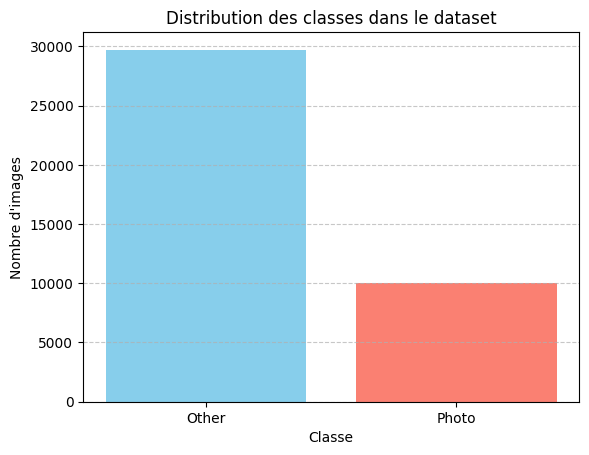

In [14]:
# Afficher la distribution des classes dans l'ensemble des classes
class_counts = {}
for class_dir in DATA_DIR.iterdir():
    if class_dir.is_dir():
        num_images = len(list(class_dir.glob("*.jpg"))) + len(list(class_dir.glob("*.png"))) + len(list(class_dir.glob("*.jpeg")))
        class_counts[class_dir.name] = num_images

# Afficher les résultats
print("\n Distribution des classes :")
for class_name, count in class_counts.items():
    print(f"{class_name} : {count} images")

# Visualisation graphique
plt.bar(class_counts.keys(), class_counts.values(), color=["skyblue", "salmon"])
plt.title("Distribution des classes dans le dataset")
plt.xlabel("Classe")
plt.ylabel("Nombre d'images")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [3]:
from pathlib import Path
from collections import Counter

counts = Counter()

for img_path in DATA_DIR.rglob("*.*"):
    if img_path.is_file():
        ext = img_path.suffix.lower()
        counts[ext] += 1

print("Nombre d'images par extension :")
for ext, count in counts.items():
    print(f"{ext} → {count} fichiers")

Nombre d'images par extension :
.jpg → 39706 fichiers


In [27]:
converted = 0
errors = 0

for img_path in DATA_DIR.rglob("*.png"):
    try:
        with Image.open(img_path) as img:
            # Convertir en RGB (supprime transparence s’il y en a)
            
            if img.mode != "RGB":
                img = img.convert("RGB")

            # Nouveau chemin avec extension .jpg
            new_path = img_path.with_suffix(".jpg")

            # Sauvegarde en JPG (haute qualité)
            img.save(new_path, "JPEG", quality=95)

        # Supprime l'ancien fichier .png
        img_path.unlink()

        converted += 1

    except Exception as e:
        print(f" Erreur avec {img_path.name} : {e}")
        errors += 1

print(f"\n {converted} images .png converties en .jpg avec succès.")
if errors:
    print(f" {errors} erreurs rencontrées pendant la conversion.")


 0 images .png converties en .jpg avec succès.


In [24]:
from pathlib import Path
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt

# Compteur des dimensions
dimensions = Counter()

# Parcourir toutes les images du dataset
for img_path in DATA_DIR.rglob("*.*"):
    with Image.open(img_path) as img:
            dimensions[img.size] += 1# img.size = (width, height)

# Trier les dimensions par fréquence
dimensions_sorted = dict(sorted(dimensions.items(), key=lambda x: x[1], reverse=True))

# Afficher un aperçu texte
print("Dimensions les plus fréquentes :")
for dim, count in list(dimensions_sorted.items())[:10]:
    print(f"{dim[0]}x{dim[1]} -> {count} images")


Dimensions les plus fréquentes :
595x842 -> 6560 images
640x480 -> 2107 images
640x427 -> 1202 images
385x526 -> 1147 images
595x792 -> 1122 images
612x792 -> 955 images
480x640 -> 715 images
640x426 -> 481 images
500x375 -> 428 images
427x640 -> 349 images


In [29]:
from PIL import Image
import hashlib

hashes = {}
duplicates = []

for img_path in DATA_DIR.rglob("*.jpg"):
    try:
        # Lire le fichier en binaire
        with open(img_path, "rb") as f:
            file_bytes = f.read()
            h = hashlib.md5(file_bytes).hexdigest()  # Hash MD5 du fichier

        if h in hashes:
            duplicates.append((img_path, hashes[h]))
        else:
            hashes[h] = img_path

    except Exception as e:
        print(f"Erreur avec {img_path} : {e}")

print(f"\n Total doublons exacts : {len(duplicates)}")



 Total doublons exacts : 689


In [28]:
from pathlib import Path
from PIL import Image

corrupted = []

for img_path in DATA_DIR.glob("*.*"):
    try:
        with Image.open(img_path) as img:
            img.verify()  # Vérifie sans charger complètement
    except Exception as e:
        print(f"Corrompue : {img_path} ({e})")
        corrupted.append(img_path)
        # Supprimer si tu veux
        # img_path.unlink()

print(f"\nTotal corrompues détectées : {len(corrupted)}")


Total corrompues détectées : 0


In [58]:
def clean_folder(folder):
    seen_hashes = set()
    for fn in os.listdir(folder):
        path = os.path.join(folder, fn)
        try:
            with Image.open(path) as img:
                img.verify()  # Corrupt?
            with open(path, "rb") as f:
                h = hashlib.md5(f.read()).hexdigest()
            if h in seen_hashes:
                print(f"Duplicate {fn}, removing.")
                os.remove(path)
                continue
            seen_hashes.add(h)
            # Convert to jpg if not already
            if not fn.lower().endswith(".jpg"):
                with Image.open(path) as img:
                    img = img.convert("RGB")
                    new_path = os.path.splitext(path)[0] + ".jpg"
                    img.save(new_path, "JPEG", quality=95)
                os.remove(path)
        except Exception as e:
            print(f"Bad file {fn}: {e}")
            os.remove(path)


In [15]:
# List of all actual folder names
PHOTO_FOLDERS = ['Photo']
OTHER_FOLDERS = ['Drawing', 'Painting', 'Text', 'Graph']

FOLDER_TO_LABEL = {}
for f in PHOTO_FOLDERS:
    FOLDER_TO_LABEL[f] = 'Photo'
for f in OTHER_FOLDERS:
    FOLDER_TO_LABEL[f] = 'Other'

In [16]:
# Créer la liste des fichiers et labels correspondants
filepaths = []
labels = []
class_names = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])
class_to_idx = {name: i for i, name in enumerate(class_names)}
print("Classes détectées :", class_names)
# for label in class_names:
#     folder = os.path.join(DATA_DIR, label)
#     for f in glob(os.path.join(folder, "*.jpg")):
#         filepaths.append(f)
#         labels.append(label)
for folder in class_names:
    class_label = FOLDER_TO_LABEL.get(folder, 'Other')  # fallback to Other if not listed
    full_path = os.path.join(DATA_DIR, folder)
    for f in glob(os.path.join(full_path, "*.jpg")):
        filepaths.append(f)
        labels.append(class_label)
# Optionnel: on convertit en tensor
filepaths_ds = tf.constant(filepaths)
labels_ds = tf.constant(labels)

Classes détectées : ['Other', 'Photo']


## Fonction de prétraitement personnalisée
On applique l'augmentation de données **uniquement à la classe "Photo"** (le nom ou l'index peut-être adapté). Les transformations tf.image sont rapides et sobres en mémoire.

In [17]:
def preprocess(filepath, label):
    # Lire et décoder l'image
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE) #Resize

    # Augmentation uniquement pour les "Photo"
    if tf.equal(label, "Photo"):  # Ici: label string, sinon tf.equal(label, 1) pour un index
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        img = tf.image.random_brightness(img, max_delta=0.1)
        img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
    img = tf.cast(img, tf.float32) / 255.0
    y = tf.cast(tf.equal(label, "Photo"), tf.int32)  # Target binaire
    return img, y

## Construction du dataset TensorFlow
La base complète est mélangée et découpée pour entraînement, validation et test. On n'utilise pas de duplication de fichiers ou réécriture sur le disque, tout passe dans la pipeline mémorisée de tensorflow.

In [18]:
# All data as (filepath, label) pairs, then shuffle and map
total_imgs = len(filepaths)
indexes = tf.range(total_imgs)
indexes = tf.random.shuffle(indexes, seed=SEED)
shuffled_paths = tf.gather(filepaths, indexes)
shuffled_labels = tf.gather(labels, indexes)

ds = tf.data.Dataset.from_tensor_slices((shuffled_paths, shuffled_labels))
ds = ds.map(preprocess, num_parallel_calls=AUTOTUNE)

# 80/10/10 Split
n_train = int(0.8 * total_imgs)
n_val = int(0.1 * total_imgs)

train_ds = ds.take(n_train).batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds   = ds.skip(n_train).take(n_val).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds  = ds.skip(n_train + n_val).batch(BATCH_SIZE).prefetch(AUTOTUNE)

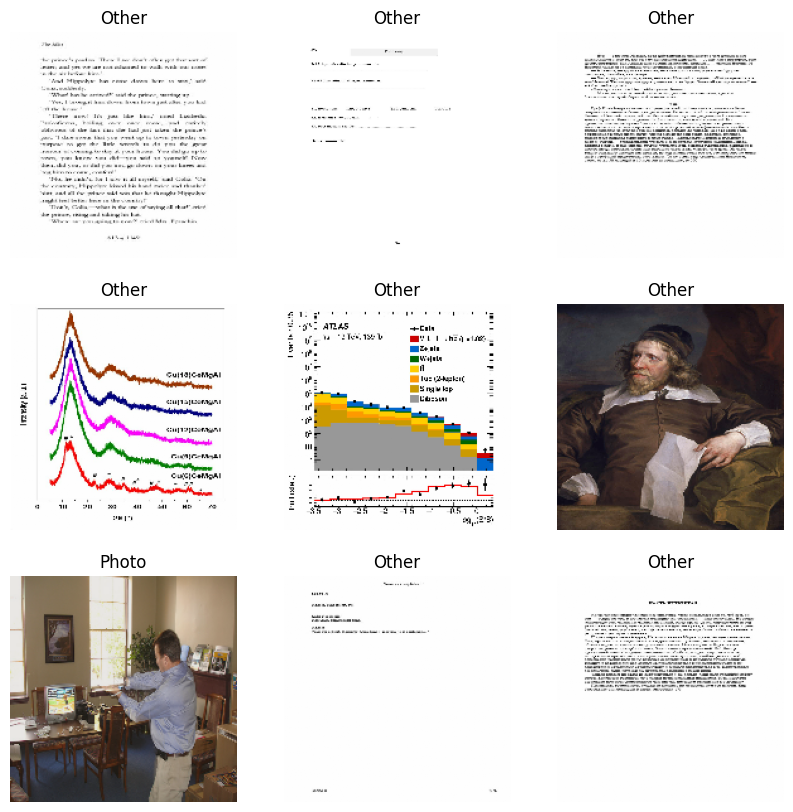

2025-10-08 14:51:23.102751: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [19]:
for images, labels in train_ds.take(1):
    batch_size = images.shape[0]
    to_show = min(9, batch_size)
    plt.figure(figsize=(10,10))
    for i in range(to_show):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy())
        # If binary: labels are 0/1, map to class name
        label_str = "Photo" if labels[i].numpy() else "Other"
        plt.title(label_str)
        plt.axis("off")
    plt.show()

### Conception des modèles

Plusieurs architectures de CNN sont conçues et testées :

- ResNet/Separable-ResNet simplifié : inspiration des architectures à connexion résiduelle, efficace pour apprendre sur des données visuelles diverses ;

- CNN simple et "strided" : classique ou avec convolution à stride pour comparaison rapide ;

- Mini-Xception : usage de convolutions séparables en profondeur pour efficacité.

Pour chaque modèle :

- Les couches, fonctions d’activation (généralement ReLU), la couche de sortie (logit ou softmax selon la méthode), le Dropout et la GlobalPooling finale sont détaillés.

- Le schéma du modèle est généré automatiquement dans le notebook (keras.utils.plot_model).

### Fonction de perte & Optimisation

Fonction de perte :

- Pour du binaire (photos vs non-photos) → BinaryCrossentropy(from_logits=True)

- Pour du multi-classes → SparseCategoricalCrossentropy(from_logits=True)

Optimiseur :

- Adam avec un taux d’apprentissage initial de 3e-4

Régularisation :

- Dropout sur couches denses et profondes

- Data augmentation

- Early-stopping sur la validation

In [20]:
def compile_for_binary_logits(model, lr=3e-4):
    model.compile(
        optimizer=keras.optimizers.Adam(lr),
        loss=keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[keras.metrics.BinaryAccuracy(name="acc")]
    )
    return model

def compile_for_multiclass_logits(model, lr=3e-4, num_classes=2):
    model.compile(
        optimizer=keras.optimizers.Adam(lr),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"]
    )
    return model

def train_model(model, train_ds, val_ds, epochs=25, name="model"):
    callbacks = [
        keras.callbacks.ModelCheckpoint(f"{name}_epoch{{epoch:02d}}.keras", save_best_only=False),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    ]
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks, verbose=2)
    return history

def evaluate_model(model, test_ds):
    return model.evaluate(test_ds, verbose=0)

Residual separable CNN (your original improved and wrapped)

Simple CNN (pooling)

Strided CNN (no pooling, strides)

Baseline small Xception-ish tweak variant
(All compiled for binary logits if NUM_CLASSES==2; else multiclass)

In [21]:
def make_residual_sep(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = layers.Rescaling(1./255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    prev = x
    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(prev)
        x = layers.add([x, residual])
        prev = x

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.25)(x)
    units = 1 if num_classes==2 else num_classes
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs, name="residual_sep")

def make_simple_cnn(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # x = data_augmentation(inputs)
    x = layers.Rescaling(1./255)(inputs)
    x = layers.Conv2D(16, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    units = 1 if num_classes==2 else num_classes
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs, name="simple_cnn")

def make_strided_cnn(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # x = data_augmentation(inputs)
    x = layers.Rescaling(1./255)(inputs)
    x = layers.Conv2D(16, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(32, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(64, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    units = 1 if num_classes==2 else num_classes
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs, name="strided_cnn")

def make_xception_tiny(input_shape, num_classes):
    # Small variant to probe depthwise separable improvements
    inputs = keras.Input(shape=input_shape)
    # x = data_augmentation(inputs)
    x = layers.Rescaling(1./255)(inputs)
    for f in [32, 64, 128]:
        x = layers.SeparableConv2D(f, 3, padding="same", activation=None)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        x = layers.MaxPooling2D()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    units = 1 if num_classes==2 else num_classes
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs, name="xception_tiny")

### Entraînement et suivi des métriques
Pour chaque modèle, on collecte l’historique de l'Accuracy et de la loss sur train et validation à chaque epoch, les courbes sont affichées côte à côte.

In [25]:
input_shape = IMAGE_SIZE + (3,)

builders = [
    make_residual_sep
    # ,
    # make_simple_cnn,
    # make_strided_cnn,
    # make_xception_tiny,
]

models = {}
histories = {}
scores_val = {}
scores_test = {}
NUM_CLASSES = 2

for build in builders:
    m = build(input_shape, NUM_CLASSES)
    if NUM_CLASSES == 2:
        compile_for_binary_logits(m)
    else:
        compile_for_multiclass_logits(m, num_classes=NUM_CLASSES)
    name = m.name
    print(f"Training {name}...")
    h = train_model(m, train_ds, val_ds, epochs=25, name=name)
    val_score = m.evaluate(val_ds, verbose=0)
    test_score = m.evaluate(test_ds, verbose=0)
    models[name] = m
    histories[name] = h
    scores_val[name] = val_score
    scores_test[name] = test_score
    print(f"{name} -> val: {val_score}, test: {test_score}")

Training residual_sep...
Epoch 1/25


2025-10-08 16:32:42.184838: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-10-08 16:32:42.307275: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-10-08 16:32:42.427033: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-10-08 16:32:42.551269: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-10-08 16:32:42.674433: E external/local_xla/xla/stream_

1986/1986 - 192s - 97ms/step - acc: 0.8513 - loss: 0.2996 - val_acc: 0.7514 - val_loss: 37.9293
Epoch 2/25


Corrupt JPEG data: 419 extraneous bytes before marker 0xd9
Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1986/1986 - 143s - 72ms/step - acc: 0.8990 - loss: 0.2265 - val_acc: 0.7514 - val_loss: 25.2538
Epoch 3/25


Corrupt JPEG data: 419 extraneous bytes before marker 0xd9
Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1986/1986 - 143s - 72ms/step - acc: 0.9186 - loss: 0.1866 - val_acc: 0.7514 - val_loss: 22.2641
Epoch 4/25


Corrupt JPEG data: 419 extraneous bytes before marker 0xd9
Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1986/1986 - 143s - 72ms/step - acc: 0.9345 - loss: 0.1545 - val_acc: 0.7514 - val_loss: 34.4025
Epoch 5/25


Corrupt JPEG data: 419 extraneous bytes before marker 0xd9
Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1986/1986 - 143s - 72ms/step - acc: 0.9479 - loss: 0.1271 - val_acc: 0.7514 - val_loss: 44.4323
Epoch 6/25


Corrupt JPEG data: 419 extraneous bytes before marker 0xd9
Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1986/1986 - 143s - 72ms/step - acc: 0.9584 - loss: 0.1038 - val_acc: 0.7514 - val_loss: 26.9611
Epoch 7/25


Corrupt JPEG data: 419 extraneous bytes before marker 0xd9
Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1986/1986 - 141s - 71ms/step - acc: 0.9676 - loss: 0.0829 - val_acc: 0.7514 - val_loss: 58.9356
Epoch 8/25


Corrupt JPEG data: 419 extraneous bytes before marker 0xd9
Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1986/1986 - 141s - 71ms/step - acc: 0.9728 - loss: 0.0727 - val_acc: 0.7514 - val_loss: 49.2641


Corrupt JPEG data: 419 extraneous bytes before marker 0xd9
Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


residual_sep -> val: [22.2630615234375, 0.7513853907585144], test: [22.80682945251465, 0.745468258857727]


## Évaluation et visualisation finale
1. Évaluation systématique sur le jeu de test

1. Matrice de confusion pour chaque modèle, affichée en grille

1. Courbes ROC/AUC et Precision-Recall (pour la version binaire si besoin)

1. Grad-CAM / Guided Grad-CAM pour comprendre « où » le modèle regarde sur une image test




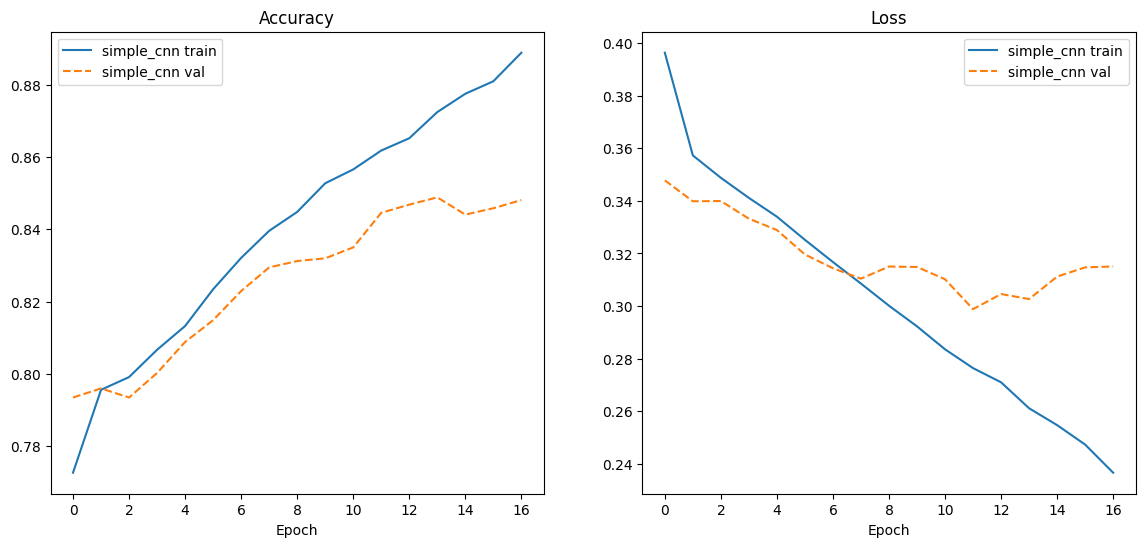

In [24]:
def plot_histories(histories_dict, metric='accuracy'):
    plt.figure(figsize=(14,6))
    # Training metric
    plt.subplot(1,2,1)
    for name, h in histories_dict.items():
        mkey = 'acc' if 'acc' in h.history else 'accuracy'
        plt.plot(h.history.get(mkey, []), label=f'{name} train')
        plt.plot(h.history.get(f'val_{mkey}', []), label=f'{name} val', linestyle='--')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    # Loss
    plt.subplot(1,2,2)
    for name, h in histories_dict.items():
        plt.plot(h.history['loss'], label=f'{name} train')
        plt.plot(h.history['val_loss'], label=f'{name} val', linestyle='--')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

plot_histories(histories)


## Confusion matrices for each model


In [33]:
labels_py = [x.decode() for x in labels_ds.numpy()]
print(Counter(labels_py))

Counter({'Other': 29713, 'Photo': 9993})


Corrupt JPEG data: 419 extraneous bytes before marker 0xd9
Corrupt JPEG data: 419 extraneous bytes before marker 0xd9
Corrupt JPEG data: 419 extraneous bytes before marker 0xd9
2025-10-08 13:46:46.805528: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


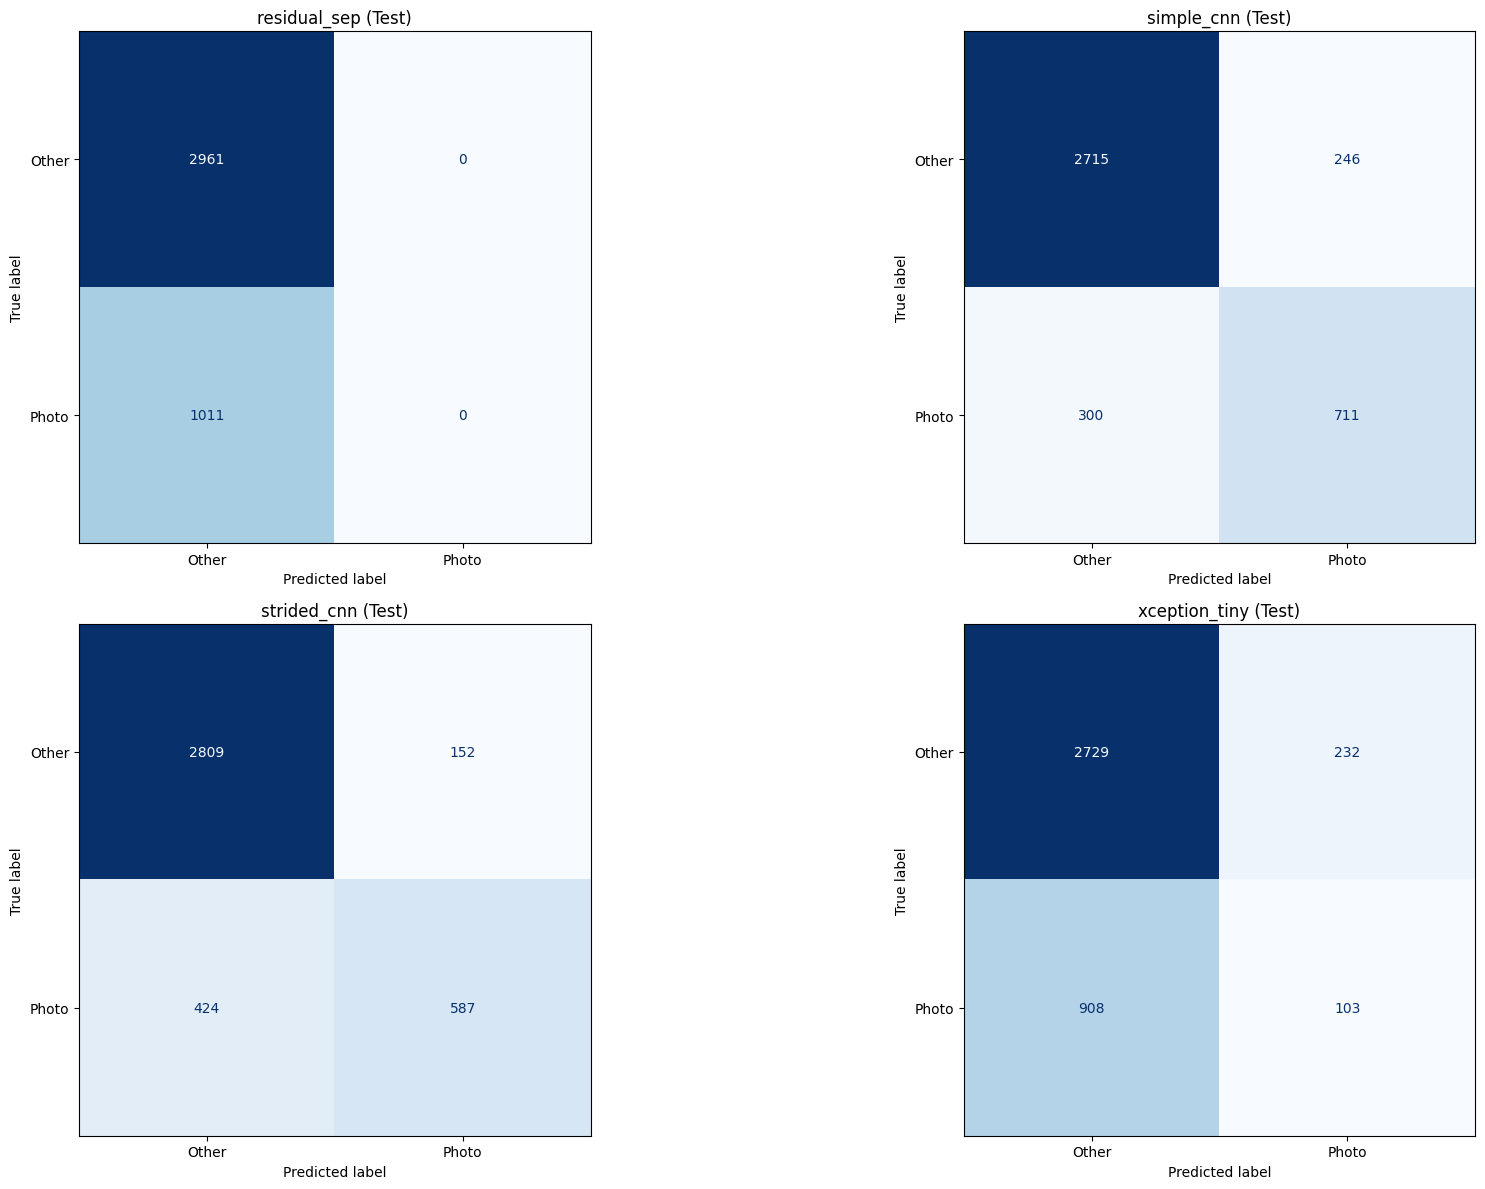

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def collect_preds(model, ds, binary=(NUM_CLASSES==2)):
    y_true, y_pred = [], []
    for batch in ds:
        images, labels = batch
        logits = model.predict(images, verbose=0)
        if binary:
            probs = tf.sigmoid(logits).numpy().reshape(-1)
            preds = (probs > 0.5).astype(int) 
            y_pred.extend(preds)
            y_true.extend(labels.numpy().astype(int).reshape(-1))
        else:
            preds = np.argmax(logits, axis=1)
            y_pred.extend(preds)
            y_true.extend(labels.numpy().astype(int).reshape(-1))
    return np.array(y_true), np.array(y_pred)

def plot_confusion_matrices(models_dict, ds, title_suffix="(Test)"):
    cols = 2
    rows = int(np.ceil(len(models_dict)/cols))
    fig, axes = plt.subplots(rows, cols, figsize=(10*cols, 6*rows))
    axes = np.array(axes).reshape(-1)
    for ax, (name, m) in zip(axes, models_dict.items()):
        y_true, y_pred = collect_preds(m, ds, binary=(NUM_CLASSES==2))
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)
        ax.set_title(f'{name} {title_suffix}')
    for ax in axes[len(models_dict):]:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plot_confusion_matrices(models, test_ds, title_suffix="(Test)")


## Grad-CAM, Guided Backprop, Guided Grad-CAM utilities


In [12]:
# Grad-CAM (general)
def gradcam_heatmap(img_batch, model, last_conv_layer_name, class_index=None):
    # img_batch shape: (1, H, W, 3)
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img_batch)
        if class_index is None:
            if preds.shape[-1] == 1:
                class_index = 0
            else:
                class_index = tf.argmax(preds[0])
        score = preds[:, class_index]
    grads = tape.gradient(score, conv_out)  # (1, h, w, c)
    pooled = tf.reduce_mean(grads, axis=(0,1,2))  # (c,)
    conv = conv_out[0]  # (h, w, c)
    heatmap = tf.tensordot(conv, pooled, axes=1)  # (h, w)
    heatmap = tf.maximum(heatmap, 0)
    denom = tf.reduce_max(heatmap)
    heatmap = heatmap / (denom + 1e-8)
    return heatmap.numpy()

@tf.custom_gradient
def GuidedBackpropRelu(x):
    def grad(dy):
        return tf.cast(dy>0, tf.float32) * tf.cast(x>0, tf.float32) * dy
    return tf.nn.relu(x), grad

def build_guided_model(model):
    def _clone(layer):
        if hasattr(layer, 'activation') and layer.activation == tf.keras.activations.relu:
            cfg = layer.get_config()
            cfg['activation'] = None
            new = layer.__class__.from_config(cfg)
            # Wrap with custom relu
            return keras.Sequential([new, layers.Activation(GuidedBackpropRelu)])
        return layer
    gb = tf.keras.models.clone_model(model, clone_function=_clone)
    gb.set_weights(model.get_weights())
    return gb

def guided_backprop(img_batch, guided_model, class_index=0):
    with tf.GradientTape() as tape:
        inputs = tf.cast(img_batch, tf.float32)
        tape.watch(inputs)
        logits = guided_model(inputs)
        target = logits[:, class_index]
    grads = tape.gradient(target, inputs).numpy()[0]  # (H, W, 3)
    return grads

def overlay_heatmap_on_image(img_rgb_uint8, heatmap_0_1, alpha=0.5):
    heat_uint8 = np.uint8(255 * heatmap_0_1)
    heat_color = cv2.applyColorMap(heat_uint8, cv2.COLORMAP_JET)
    heat_color = cv2.cvtColor(heat_color, cv2.COLOR_BGR2RGB)
    overlay = cv2.addWeighted(img_rgb_uint8, 1-alpha, heat_color, alpha, 0)
    return overlay


## Explain one image across all models


In [13]:
# Load a test image
IMG_PATH = "/mnt/c/Users/octav/Pictures/tensorflow test/photo_0069.jpg"
img_pil = keras.utils.load_img(IMG_PATH, target_size=IMAGE_SIZE)
img_rgb = np.array(img_pil).astype("uint8")
img_batch = np.expand_dims(img_rgb, 0)

def last_conv_name(model):
    # Try last conv layer
    convs = [l.name for l in model.layers if isinstance(l, layers.Conv2D) or isinstance(l, layers.SeparableConv2D)]
    return convs[-1] if convs else None

def predict_probs(model, img_batch):
    logits = model.predict(img_batch, verbose=0)
    if logits.shape[-1] == 1:
        p = tf.sigmoid(logits)[0,0].numpy()
        return np.array([1-p, p]), [f"class_{i}" for i in range(2)]
    else:
        p = tf.nn.softmax(logits)[0].numpy()
        return p, class_names

cols = 3
rows = len(models)
plt.figure(figsize=(5*cols, 4*rows))
i = 1
for name, m in models.items():
    lc = last_conv_name(m)
    probs, labels = predict_probs(m, img_batch)
    class_idx = int(np.argmax(probs))
    heat = gradcam_heatmap(img_batch, m, lc, class_index=class_idx)
    heat_resized = cv2.resize(heat, IMAGE_SIZE[::-1])  # (W,H) swap
    overlay = overlay_heatmap_on_image(img_rgb, heat_resized)

    # Guided backprop + Guided Grad-CAM
    gb_model = build_guided_model(m)
    gb_grads = guided_backprop(img_batch, gb_model, class_index=class_idx)  # (H,W,3)
    guided_gradcam = gb_grads * heat_resized[..., None]
    guided_gradcam_norm = guided_gradcam / (np.max(np.abs(guided_gradcam)) + 1e-8)

    # Plot: original, Grad-CAM, Guided Grad-CAM
    plt.subplot(rows, cols, i); i+=1
    plt.title(f"{name}\nOriginal")
    plt.imshow(img_rgb); plt.axis('off')

    plt.subplot(rows, cols, i); i+=1
    plt.title(f"{name}\nGrad-CAM: {labels[class_idx]} {probs[class_idx]:.2f}")
    plt.imshow(overlay); plt.axis('off')

    plt.subplot(rows, cols, i); i+=1
    plt.title(f"{name}\nGuided Grad-CAM")
    # normalize to 0-1 for display
    vis = (guided_gradcam_norm - guided_gradcam_norm.min()) / (guided_gradcam_norm.max() - guided_gradcam_norm.min() + 1e-8)
    plt.imshow(vis); plt.axis('off')

plt.tight_layout(); plt.show()


2025-10-07 08:34:35.673895: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-10-07 08:34:35.817301: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-10-07 08:34:37.180645: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-10-07 08:34:37.343227: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-10-07 08:34:37.844862: E external/local_xla/xla/stream_

InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} slice index 1 of dimension 1 out of bounds. [Op:StridedSlice] name: strided_slice/

<Figure size 1500x1600 with 0 Axes>

## Side-by-side metrics comparison


In [28]:
# Summarize test accuracy/loss for each model
for name, m in models.items():
    metrics = m.metrics_names
    print(f"{name} test -> {dict(zip(metrics, scores_test[name]))}")


residual_sep test -> {'loss': 3.9029030799865723, 'compile_metrics': 0.745468258857727}
simple_cnn test -> {'loss': 0.28794801235198975, 'compile_metrics': 0.8590130805969238}
strided_cnn test -> {'loss': 0.30819401144981384, 'compile_metrics': 0.8361027240753174}
xception_tiny test -> {'loss': 0.48097044229507446, 'compile_metrics': 0.7202920317649841}


## Optional: ROC and PR curves per model (binary)


Corrupt JPEG data: 419 extraneous bytes before marker 0xd9
Corrupt JPEG data: 419 extraneous bytes before marker 0xd9
Corrupt JPEG data: 419 extraneous bytes before marker 0xd9
Corrupt JPEG data: 419 extraneous bytes before marker 0xd9
Corrupt JPEG data: 419 extraneous bytes before marker 0xd9
/tmp/ipykernel_875095/2135926074.py:30: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  ap = np.trapz(prec[::-1], rec[::-1])  # rough AP
Corrupt JPEG data: 419 extraneous bytes before marker 0xd9
/tmp/ipykernel_875095/2135926074.py:30: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  ap = np.trapz(prec[::-1], rec[::-1])  # rough AP
Corrupt JPEG data: 419 extraneous bytes before marker 0xd9
2025-10-08 13:58:32.052518: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RAN

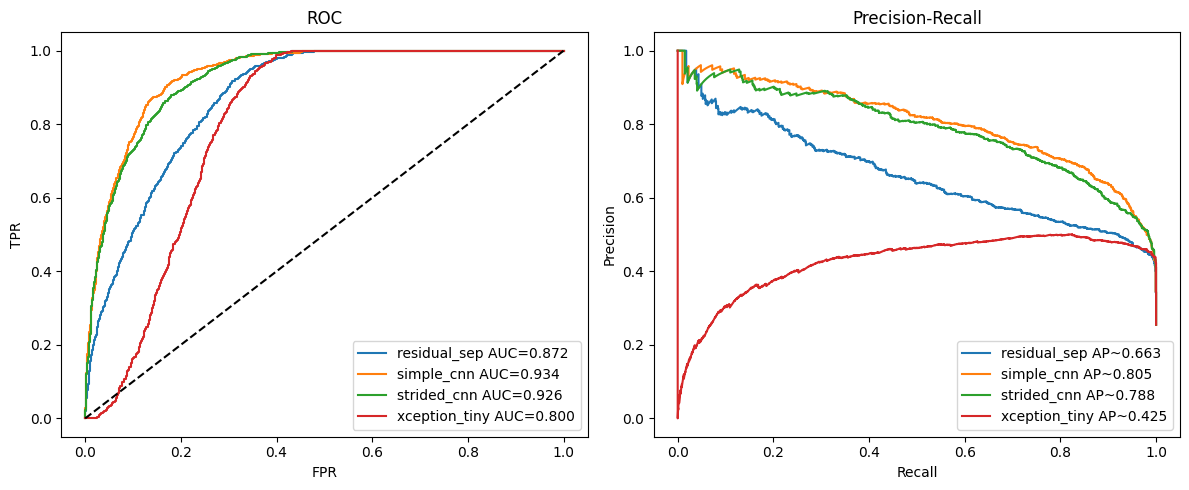

In [29]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

if NUM_CLASSES==2:
    plt.figure(figsize=(12,5))
    # ROC
    plt.subplot(1,2,1)
    for name, m in models.items():
        # collect probabilities
        y_true, y_prob = [], []
        for x, y in test_ds:
            logits = m.predict(x, verbose=0)
            p = tf.sigmoid(logits).numpy().reshape(-1)
            y_prob.extend(p)
            y_true.extend(y.numpy().reshape(-1))
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} AUC={roc_auc:.3f}')
    plt.plot([0,1],[0,1],'k--'); plt.title("ROC")
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend()

    # PR
    plt.subplot(1,2,2)
    for name, m in models.items():
        y_true, y_prob = [], []
        for x, y in test_ds:
            logits = m.predict(x, verbose=0)
            p = tf.sigmoid(logits).numpy().reshape(-1)
            y_prob.extend(p); y_true.extend(y.numpy().reshape(-1))
        prec, rec, _ = precision_recall_curve(y_true, y_prob)
        ap = np.trapz(prec[::-1], rec[::-1])  # rough AP
        plt.plot(rec, prec, label=f'{name} AP~{ap:.3f}')
    plt.title("Precision-Recall"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend()
    plt.tight_layout(); plt.show()
